In [1]:
import pandas
import math
%matplotlib inline

rename_dict = {}
for i in range(1995, 2015):
    rename_dict[' ' + str(i)] = str(i)
    
country_code2country = {}
f = open("who-mortality/country_codes.csv")
f.readline()
for s in f.readlines():
    splitted = s.rstrip().split(',')
    code = splitted[0]
    name = ','.join(splitted[1:])
    country_code2country[int(code)] = name
f.close()

article_subjects = ["genetics", "psychology", "physiology", "molecular"]

sex2int = {"Persons" : 3, "Male" : 1, "Female" : 2}

In [2]:
disease = pandas.read_excel("who-desease-burden/GHE2015_YLD-2015-country.xls", sheet_name=1, header=6)
mortality = pandas.read_csv("who-mortality/mort-no-nan-col.csv")
causes_of_death = pandas.read_csv("who-mortality/causes-of-death.csv", sep=";")


/usr/local/lib/python3.5/dist-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (0,1,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
articles = pandas.DataFrame()
for subj in article_subjects:
    for year in range(2007, 2016):
        current_frame = pandas.read_excel("scimago-articles/scimago/data/{}/{}.xls".format(subj, year))
        
        current_frame["Year"] = (pandas.Series([year] * len(current_frame)))
        current_frame["Subject"] = (pandas.Series([subj] * len(current_frame)))

        articles = articles.append(current_frame)

In [4]:
i = 0
def choose_last_value(a):
    a, b, c, d = a
    if pandas.notnull(d):
        return d
    elif pandas.notnull(c):
        return c
    elif pandas.notnull(b):
        return b
    return a


In [5]:
mortality["Country"] = mortality["Country"].map(country_code2country.get)

In [6]:
health_exp = pandas.read_csv("who-health-expenditure/exp-years-percent.csv", header=1)
health_exp = health_exp.rename(columns=rename_dict)
health_exp = health_exp.set_index("Country")
health_exp = health_exp.drop(["Bolivia (Plurinational State of)"])
gdp = pandas.read_csv("who-health-expenditure/worldGDP.csv", header = 2)
gdp = gdp.drop(gdp.loc[:, "Country Code": "1990"], axis=1)

del gdp["Unnamed: 62"]
del gdp["2017"] # empty column
gdp = gdp.set_index("Country Name")
gdp.loc["Bolivia (Plurinational State of)"] = gdp.loc["Bolivia"]
gdp.loc["Bahamas"] = gdp.loc["Bahamas, The"]
gdp.loc["Côte d'Ivoire"] = gdp.loc["Cote d'Ivoire"]
gdp.loc["Congo"] = gdp.loc["Congo, Rep."]
gdp.loc["Czechia"] = gdp.loc["Czech Republic"]
gdp.loc["United States of America"] = gdp.loc["United States"]
gdp.loc["Egypt"] = gdp.loc["Egypt, Arab Rep."]
gdp.loc['United Kingdom of Great Britain and Northern Ireland'] = gdp.loc["United Kingdom"]

# different sources differ in countries' names

health_exp_abs_pc = pandas.DataFrame(health_exp).copy()
broken_names = []
for i in health_exp.index:
    for j in health_exp.columns:
        try:
            health_exp_abs_pc.loc[j, i] *= gdp[j][i]
            
            #health_exp_abs_pc.loc[j, i] /= basic["Population (\'000) (2)"][j]
            health_exp_abs_pc.loc[j, i] = math.log(float(health_exp_abs_pc[j][i]))
        except:
            #print(i, j)
            broken_names.append(i)
#'''


In [7]:
disease_names = disease.loc[:, "GHE cause":"Member State\n(See Notes for explanation of colour codes)"]
disease["Name"] = disease_names.apply(choose_last_value, axis=1)
basic = disease[disease["GHE cause"].notnull()]
basic["Sex"] = pandas.DataFrame(basic["Sex"].map(sex2int))
basic = basic.drop(basic.loc[:, "Unnamed: 2": "Member State\n(See Notes for explanation of colour codes)"].columns, axis=1)
basic = basic[basic["Sex"].notnull()]
basic = basic.set_index("Name").transpose()

#basic = disease.loc[:, "Afghanistan":"Zimbabwe"][2:15]
#basic = basic.transpose()

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


### Сравнение статистик Китая и Индии

/usr/local/lib/python3.5/dist-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


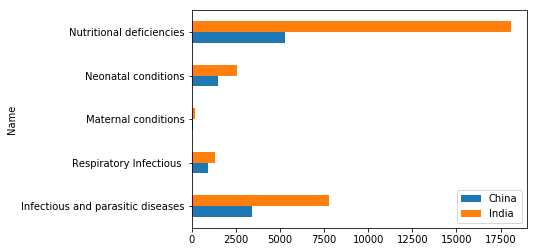

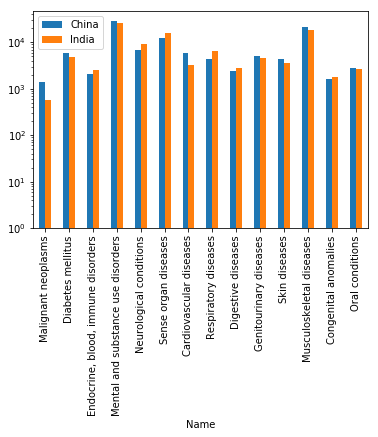

In [8]:
 for i in basic.columns:
    try:
        basic[i] = pandas.to_numeric(basic[i])
        basic[i + " r"] = basic[i] / basic["Population (\'000) (2)"] * 1000
    except:
        del basic[i]
        
        


filtered_small = basic[basic.iloc[:, 1] < 100000]
#filtered_small.plot.scatter(x="Population ('000) (2)", y="Digestive diseases")
filtered_large = basic[basic.iloc[:, 1] > 100000].transpose()

filtered_large_comm = filtered_large.iloc[2:8] # all communicable diseases
filtered_large_comm = filtered_large_comm[1:]
plcot_1 = filtered_large_comm.plot.barh(by = ["China", "India"])

filtered_large_ncomm = filtered_large.loc["Noncommunicable diseases":"Oral conditions"]
filtered_large_ncomm = filtered_large_ncomm[1:]
plot_2 = filtered_large_ncomm.plot.bar(by = ["China", "India"], log=True)
filtered_large_comm.to_json("../docs/resources/india_china_comm.json")
filtered_large_ncomm.to_json("../docs/resources/india_china_ncomm.json")

В Индии население немногим меньше, чем в Китае, в обеих странах более миллиарда жителей. Сравним показатели заболеваемостей.

* Первый график -- заразные заболевания, и на графике видно, что в Индии во всех категориях таких заболеваний больных в 2-4 раза больше.
* Второй график -- незаразные заболевания (логарифмическая шкала, чтобы лучше видеть), здесь совсем другая ситуация, заболевших примерно поровну (всего), но выделяется колонка "Злокачественные новообразования", значение для Китая больше в 3 раза!


## Страны с высокими показателями нек. видов заболеваний

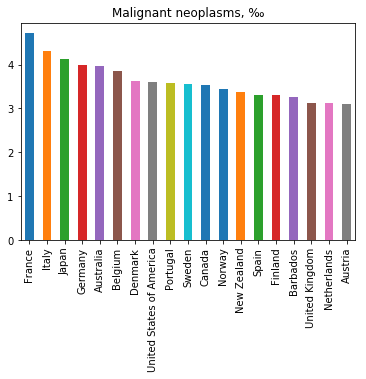

In [9]:
oncology = basic.sort_values(by="Malignant neoplasms r", ascending = False)
max_relative_neoplasms = oncology.iloc[1:20] #first is sex (garbage)
max_relative_neoplasms.plot.bar(by = "", y="Malignant neoplasms r", legend=False, title="Malignant neoplasms, ‰")
max_relative_neoplasms["Malignant neoplasms r"].to_json("../docs/resources/neoplasms.json")

Мы видим, что больше всего люди страдают от злокачественных опухолей в продвинутых, экономически благополучных европейских странах. Барбадос?


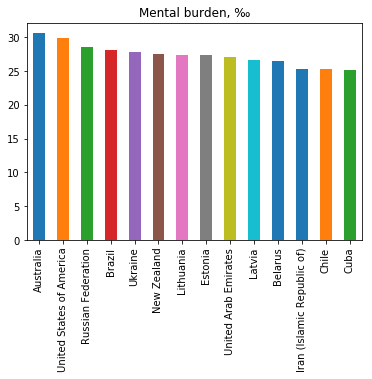

In [10]:
mental_disorders = basic.sort_values(by="Mental and substance use disorders r", ascending = False)
max_relative_mental_burden = mental_disorders.iloc[1:15] #first is sex (garbage)
max_relative_mental_burden.plot.bar(by = "", y="Mental and substance use disorders r", legend=False, title="Mental burden, ‰")
max_relative_mental_burden["Mental and substance use disorders r"].to_json("../docs/resources/mental.json")

В этом графике очень много стран бывшего Советского Союза по сравнению с предыдущим


#### Вложения бюджета в медицину `($ per capita)` и уровень заболеваемости

In [11]:
burden_and_expenditure = (basic.transpose().append(health_exp_abs_pc["2014"])).transpose()
burden_and_expenditure = (burden_and_expenditure.transpose().append(health_exp_abs_pc["2009"])).transpose()

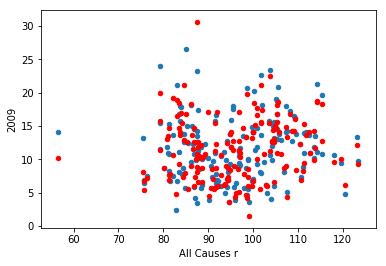

In [12]:
noncomm_expenditure = burden_and_expenditure.plot.scatter(x="All Causes r", y='2014')
burden_and_expenditure.plot.scatter(x="All Causes r", y='2009', ax=noncomm_expenditure, color="red")

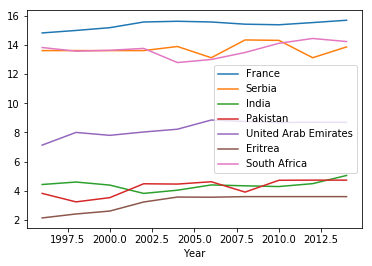

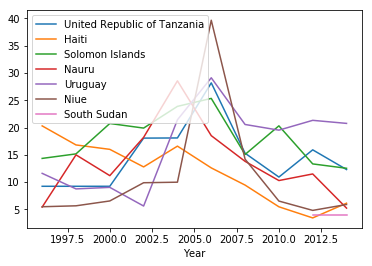

In [42]:
diff = pandas.Series()
min_exp = pandas.Series()
max_exp = pandas.Series()
for i in health_exp_abs_pc.index:
    
    min_exp[i] = health_exp_abs_pc.loc[i, "2006"]
    max_exp[i] = health_exp_abs_pc.loc[i, "2006"]
    for j in health_exp_abs_pc.columns:
        min_exp[i] = min(min_exp[i], health_exp_abs_pc.loc[i, j])
        max_exp[i] = max(max_exp[i], health_exp_abs_pc.loc[i, j])
    diff[i] = max_exp[i] - min_exp[i]
diff = diff.sort_values()
lowest_exp = pandas.DataFrame()
for i in diff[:7].index:
    lowest_exp[i] = health_exp_abs_pc.loc[i]

lowest_exp["Year"] = pandas.to_numeric(lowest_exp.index)

lowest_exp = lowest_exp[lowest_exp["Year"] % 2 == 0]
lowest_exp.plot.line(x = "Year")

highest_exp = pandas.DataFrame()
for i in diff[-7:].index:
    highest_exp[i] = health_exp_abs_pc.loc[i]
highest_exp.loc["2012":"2002", :].to_json("../docs/resources/highest-exp.json")
highest_exp["Year"] = pandas.to_numeric(highest_exp.index)

highest_exp = highest_exp[highest_exp["Year"] % 2 == 0]
highest_exp.plot.line(x = "Year")
diff["Russia"] = diff["Russian Federation"]
diff["Czech Republic"] = diff["Czechia"]
diff["United Kingdom"] = diff["United Kingdom of Great Britain and Northern Ireland"]
diff["Iran"] = diff["Iran (Islamic Republic of)"]
diff["Venezuela"] = diff["Venezuela (Bolivarian Republic of)"]
diff["Vietnam"] = diff["Viet Nam"]
diff.to_json("../docs/resources/exp-map.json")


Посмотрели на страны с наибольшей разницей вклада в медицину между 2006 и 2014 годом, такой странный пик у этих стран в 2006 году. А в стране Niue в 2012 году видим, что на одного человека в год тратили 5$, а
в `2006 - 40$`. Воспользовавшись поиском, находим, что в 2004 году Циклон [Хета](http://www.seafriends.org.nz/indepth/cyclone_heta.htm) произвёл на острове большие разрушения и надо было строить новый госпиталь (это маленькое островное гос-во, с территорией 18х23 км), госпиталей мало.

Посмотрели на другую сторону таблицы, и видим, что тут никаких резких отклонений нет. Эти страны не зря называются развивающимися: расходы на медицину хоть и колеблются, но имеют тенденцию расти.

In [14]:
#for i in diff.index:
#    mortality.loc[i, "Exp Difference"] = diff[i]
#mortality.sort_values("Exp Difference")[:10].plot.bar(y = "All Causes r")
mortality_homicide = mortality[(("X85" <= mortality["Cause"]) & (mortality["Cause"] <= "Y09")) | (mortality["Cause"] == "UE64")] 
homicide_total = pandas.DataFrame()
countries = set(mortality_homicide["Country"])
years = range(2005, 2016)
for c in countries:
    for y in years:
        homicide_total.loc[c, y] = mortality_homicide[(mortality_homicide["Country"] == c) & (mortality_homicide["Year"] == y)]["Deaths1"].sum()
        if homicide_total.loc[c, y] == 0 and y > 2005:
            homicide_total.loc[c, y] = homicide_total.loc[c, y - 1]

Dominican Republic
Venezuela
South Africa
Iraq
Mexico
Brazil
Philippines
Colombia
Ecuador
Thailand
Jamaica
Guatemala
Republic of Korea
Uzbekistan


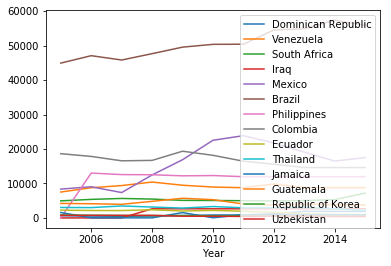

In [15]:
homicide_diff = homicide_total[2015].copy()
for i in homicide_diff.index:
    homicide_diff[i] = int(homicide_diff[i]) - homicide_total.loc[i, 2005]
homicide_diff = homicide_diff.sort_values()
top_homicide = pandas.DataFrame()
for i in range(-7, 7):
    top_homicide[homicide_diff.index[i]] = pandas.to_numeric(homicide_total.loc[homicide_diff.index[i]])
    print(homicide_diff.index[i])
for i in top_homicide.index:
    top_homicide.loc[i, "Year"] = int(i)
    
top_homicide.plot.line(x = "Year")
top_homicide.to_html("../docs/min_max_homicides.html")

Среди стран, в которых убийств стало больше, много стран Центральной и Латинской Америки. В Бразилии, например, стало на 20% больше (смотри таблицу на сайте). Но в то же время в Колумбии их количество падает. Также и в Мексике, пик пришёлся на 2011 год. В 2006 году к власти пришёл новый президент, за 6 лет его правления количество насильственных смертей выростло в 2 раза, в 2012 году власть сменилась, и преступность стала падать. 

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015
NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Iraq,0.0,0.0,0.0,4246.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Colombia,1203.0,1252.0,1068.0,1428.0,1307.0,1420.0,1194.0,1297.0,1127.0,0.0,0.0
Saudi Arabia,0.0,0.0,0.0,0.0,208.0,0.0,0.0,5609.0,0.0,0.0,0.0
South Africa,34695.0,35135.0,20128.0,6479.0,6684.0,6721.0,6421.0,7238.0,7557.0,8176.0,3415.0
Philippines,0.0,610.0,956.0,4731.0,866.0,922.0,685.0,0.0,0.0,0.0,0.0
Slovakia,272.0,3062.0,2968.0,480.0,501.0,212.0,0.0,252.0,193.0,221.0,0.0
Egypt,6545.0,7153.0,6628.0,6573.0,6606.0,7392.0,7526.0,4600.0,1506.0,1252.0,5889.0
Thailand,2291.0,2271.0,16033.0,16024.0,16491.0,9894.0,9329.0,9494.0,8016.0,7694.0,8685.0
Brazil,4660.0,4428.0,5009.0,5637.0,5729.0,4586.0,4784.0,5084.0,4523.0,4641.0,4546.0


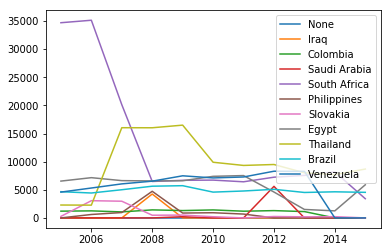

In [16]:
mortality_undetermined = mortality[(("Y10" <= mortality["Cause"]) & (mortality["Cause"] <= "Y34")) | (mortality["Cause"] == "UE65")] 
mortality_undetermined["Deaths1"] = pandas.to_numeric(mortality_undetermined["Deaths1"])
mortality_undetermined = mortality_undetermined.sort_values("Deaths1", ascending=False)
undetermined_countries = set()
for i in list(mortality_undetermined["Country"]):
    if (len(undetermined_countries) > 10):
        break
    undetermined_countries.add(i)

#for i in 
    
undetermined_c_df = pandas.DataFrame()
for i in undetermined_countries:
    for j in years:
        undetermined_c_df.loc[i, j] = mortality_undetermined[(mortality_undetermined["Country"] == i) & 
                 
                                                             (mortality_undetermined["Year"] == j)]["Deaths1"].sum()
undetermined_c_df.transpose().plot.line()
undetermined_c_df

```Undetermined intent is only for use when there is specific documentation in the record that the intent of the injury cannot be determined. ``` Очень много очень сильных перепадов. 
* Возьмём Таиланд. В 2007 году смертей такого рода стало больше в 8 раз! Открываем вики... Переворот в Таиланде в конце 2006 года и кризис до 2010. 

,Russian Federation,United States of America,Great Britain,France,Japan,Germany,Canada,Italy,Year
2014,9.49,21.29,16.52,15.69,20.28,19.65,18.77,13.65,2014
2013,9.84,20.78,16.52,15.62,20.12,19.25,18.57,13.66,2013
2012,10.18,20.08,16.21,15.53,20.05,18.81,18.57,13.77,2012
2011,10.03,19.46,16.20,15.61,19.72,18.58,18.40,14.19,2011
2010,9.72,18.97,15.93,15.38,19.36,18.15,18.23,14.56,2010
2009,10.06,18.68,16.05,15.41,18.52,18.31,18.12,14.18,2009
2008,10.39,18.92,15.34,15.42,18.59,18.13,18.01,14.30,2008
2007,10.21,19.01,15.69,15.54,18.71,18.06,17.84,13.87,2007
2006,10.77,19.04,15.66,15.57,18.35,17.58,17.58,14.16,2006
2005,11.75,18.47,15.35,15.63,18.27,17.33,17.50,14.10,2005


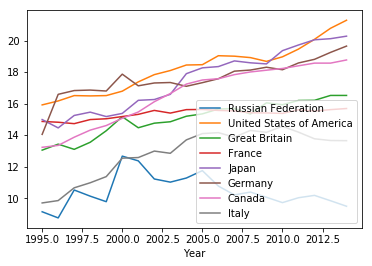

In [26]:
big_8 = ["Russian Federation", "United States of America", "United Kingdom of Great Britain and Northern Ireland",
        "France", "Japan", "Germany", "Canada", "Italy"]

big_8_health_exp = pandas.DataFrame()
for i in big_8:
    big_8_health_exp[i] = health_exp_abs_pc.loc[i]
big_8_health_exp["Year"] = pandas.to_numeric(big_8_health_exp.index)

big_8_health_exp = big_8_health_exp.rename(lambda x : "Great Britain" if x == big_8[2] else x, axis = 1)
big_8_health_exp.plot.line(x = "Year")
big_8_health_exp.loc[:, "Russian Federation":"Italy"].to_json("../docs/resources/health_exp.json")
big_8_health_exp


__Неожиданный факт__: в 2014 году в РФ такое же финансирование медицины, как и в 1996, и падает с 2006 года.

__Неожиданный факт №2__: в 2014 же году РФ перестала входить в её состав, но и данные у нас до 2014.

### Инфекционные заболевания: интересные точки

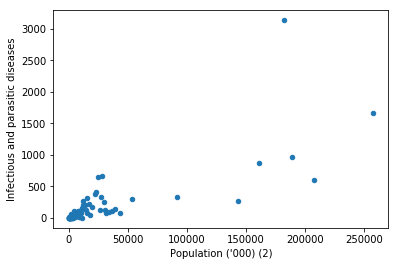

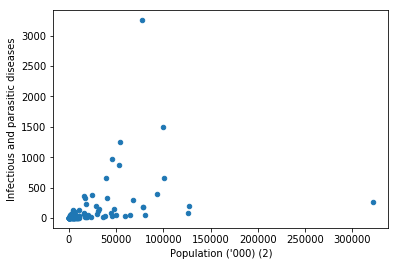

In [18]:
filtered_bae = burden_and_expenditure[burden_and_expenditure["Population (\'000) (2)"] < 1000000]
filtered_bae[10 > filtered_bae['2014']].plot.scatter(x="Population ('000) (2)", y="Infectious and parasitic diseases")
filtered_bae[10 <= filtered_bae['2014']].plot.scatter(x="Population ('000) (2)", y="Infectious and parasitic diseases")
#filtered_bae

Графики (страны разделены по низкому бюджету медицины и высокому), на которых видим, что в двух странах очень сильные всплески инфекционных заболеваний, что же это за страны?

In [19]:
filtered_bae[filtered_bae["Infectious and parasitic diseases"] > 2000]

Name,Population ('000) (2),All Causes,"Communicable, maternal, perinatal and nutritional conditions",Infectious and parasitic diseases,Respiratory Infectious,Maternal conditions,Neonatal conditions,Nutritional deficiencies,Noncommunicable diseases,Malignant neoplasms,...,Genitourinary diseases r,Skin diseases r,Musculoskeletal diseases r,Congenital anomalies r,Oral conditions r,Injuries r,Unintentional injuries r,Intentional injuries r,2014,2009
Democratic Republic of the Congo,77267.0,8826.190780,4385.637341,3254.203609,117.850021,22.874782,86.007184,904.701745,4103.496904,27.499229,...,2.221148,2.889003,7.077162,0.969804,1.553043,4.362231,3.948021,0.414210,11.06,18.69
Nigeria,182202.0,17221.356446,6259.598770,3137.938561,178.064189,63.141386,217.853307,2662.601328,9833.365459,64.733101,...,2.667187,2.441389,7.835746,0.720120,1.151731,6.193084,5.533613,0.659471,8.17,7.37


Странно, что сюда не попали другие африканские страны

## Научные публикации

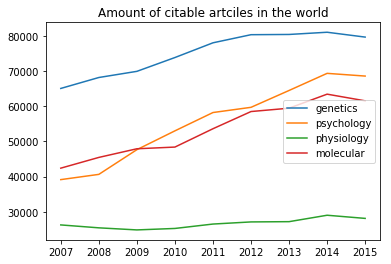

In [20]:
articles_total = pandas.DataFrame()
articles_subject = {}
#artticles[articles["Year"] == year & articles["Subject"] == subj]
for subj in article_subjects:
    #articles_total[subj] = pandas.Series([0] * 10)
    articles_subject[subj] = articles[articles["Subject"] == subj]
    for year in range(2007, 2016):
        articles_total.loc[year, subj] = 0
    for year in range(2007, 2016):
        articles_total.loc[year, subj] += articles_subject[subj][articles_subject[subj]["Year"] == year]["Citable documents"].sum()
        pass
articles_total.plot.line(title="Amount of citable artciles in the world").get_figure().savefig("../docs/articles_stats.png")

export_table = open("../docs/articles_stats.html", "w")
print(articles_total.to_html(), file=export_table)
export_table.close()

Как мы видим, количество статей по физиологии почти не меняется, а по остальным 3 из выбранных наук растёт. Хотя количество статей по генетике остановило рост в 2012 году. Странно.

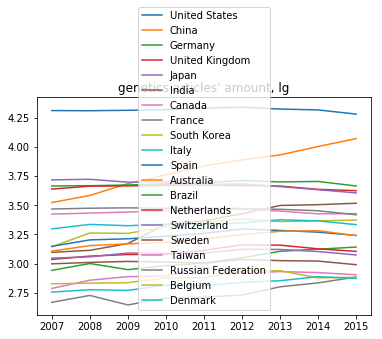

In [21]:
genetics_2015 = articles_subject["genetics"][articles_subject["genetics"]["Year"] == 2015].sort_values("Citable documents", ascending=False)
top_20_g_countries = list(genetics_2015[:20]["Country"])

filtered_top_g = pandas.DataFrame()
for country in top_20_g_countries:
    for year in range(2007, 2016):
        filtered_top_g.loc[year, country] = math.log(articles_subject["genetics"][(articles_subject["genetics"]["Country"] == country) 
                                                                     & (articles_subject["genetics"]["Year"] == year)]["Citable documents"].iloc[0], 10)
        

filtered_top_g.plot.line(title="genetics articles' amount, lg") # TODO нормально это нарисовать ?!

Можем увидеть, что из США выходит наибольшее количество статей по генетике. Тем не менее, в последние годы их количество начало снижаться (с 2012, как раз, когда на пред. графике закончился рост), а количество статей из Китая быстро увеличивается. Если приглядеться, ещё значительный рост количества статей наблюдается у Швеции.